In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF" -O hw3_data.zip && rm -rf /tmp/cookies.txt
!unzip -qq hw3_data.zip -d dul_2021/Homework/hw5/data
!rm hw3_data.zip
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 235, done.
remote: Counting objects: 100% (235/235), done.
remote: Compressing objects: 100% (121/121), done.
remote: Total 235 (delta 106), reused 210 (delta 89), pack-reused 0
Receiving objects: 100% (235/235), 30.54 MiB | 36.37 MiB/s, done.
Resolving deltas: 100% (106/106), done.
--2021-12-02 13:31:06--  https://docs.google.com/uc?export=download&confirm=g0oE&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF
Resolving docs.google.com (docs.google.com)... 142.251.45.14, 2607:f8b0:4004:83e::200e
Connecting to docs.google.com (docs.google.com)|142.251.45.14|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0c-54-docs.googleusercontent.com/docs/securesc/9mcfnu25joqm8vuojqrfvheqa4i0ivl2/kbp4e7amc4dhv30ngl8mmvtdsf2fkrg9/1638451800000/06419056966375271799/13661738355312033573Z/1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF?e=download [following]
--2021-12-02 13:31:07--  https://doc-0c-54-docs.googleuserconte

In [2]:
from dul_2021.utils.hw5_utils import *

In [16]:
plt.rcParams["axes.labelsize"] = 25.
plt.rcParams["xtick.labelsize"] = 20.
plt.rcParams["ytick.labelsize"] = 20.
plt.rcParams["legend.fontsize"] = 18.

plt.rcParams["figure.figsize"] = [11., 8.]

# Question 1: VAEs on Images
In this question, you will train VAE models on image datasets. Execute the cell below to visualize the two datasets (colored shapes, and [SVHN](http://ufldl.stanford.edu/housenumbers/)).

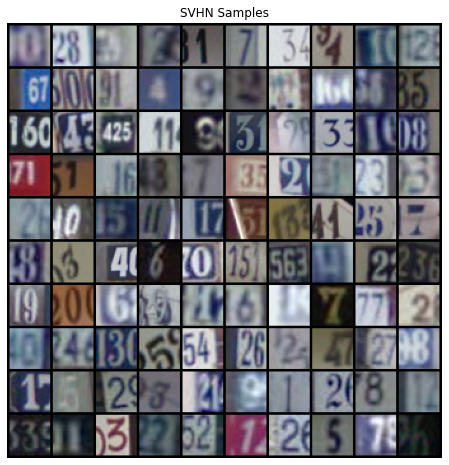

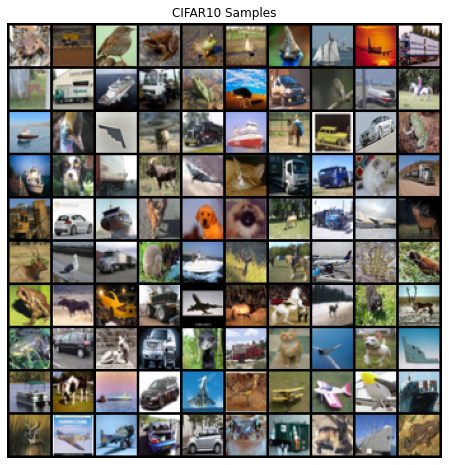

In [17]:
visualize_svhn()
visualize_cifar10()

## Part (a) VAE
In this part, implement a standard VAE with the following characteristics:

*   16-dim latent variables $z$ with standard normal prior $p(z) = N(0,I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), I)$, where $\mu_\phi(z)$ is the mean vector. (We are not learning the covariance of the decoder)

You can play around with different architectures and try for better results, but the following encoder / decoder architecture below suffices (Note that image input is always $32\times 32$.
```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)

Encoder
    conv2d(3, 32, 3, 1, 1)
    relu()
    conv2d(32, 64, 3, 2, 1) # 16 x 16
    relu() 
    conv2d(64, 128, 3, 2, 1) # 8 x 8
    relu()
    conv2d(128, 256, 3, 2, 1) # 4 x 4
    relu()
    flatten()
    linear(4 * 4 * 256, 2 * latent_dim)

Decoder
    linear(latent_dim, 4 * 4 * 128)
    relu()
    reshape(4, 4, 128)
    transpose_conv2d(128, 128, 4, 2, 1) # 8 x 8
    relu()
    transpose_conv2d(128, 64, 4, 2, 1) # 16 x 16
    relu()
    transpose_conv2d(64, 32, 4, 2, 1) # 32 x 32
    relu()
    conv2d(32, 3, 3, 1, 1)
```

You may find the following training tips helpful
*   When computing reconstruction loss and KL loss, average over the batch dimension and **sum** over the feature dimension
*   When computing reconstruction loss, it suffices to just compute MSE between the reconstructed $x$ and true $x$ (you can compute the extra constants if you want)
*   Use batch size 128, learning rate $10^{-3}$, and an Adam optimizer




**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from your trained VAE
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)
5. Interpolations of length 10 between 10 pairs of test images from your VAE (100 images total)



### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [28]:
import torch
import torch.nn as nn

In [39]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=16):
        super().__init__()
        conv_seq = nn.Sequential(self.block(3, 32, stride=1), 
                                 self.block(32, 64), 
                                 self.block(64, 128),
                                 self.block(128, 256))

        self.encoder = nn.Sequential(conv_seq, 
                                     nn.Flatten(), 
                                     nn.Linear(4 * 4 * 256, 2 * latent_dim))
        
    def block(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1):
        conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        return nn.Sequential(conv, nn.ReLU())

    def forward(self, x):
        return self.encoder(x)

In [61]:
class Decoder(nn.Module):
    def __init__(self, latent_dim=16):
        super().__init__()
        self.linear = nn.Sequential(nn.Linear(latent_dim, 4 * 4 * 128),
                                    nn.ReLU())
        
        self.conv_seq = nn.Sequential(self.block(128, 128), 
                                      self.block(128, 64), 
                                      self.block(64, 32),
                                      nn.Conv2d(32, 3, 3, 1, 1))
        
    def block(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1):
        conv_t = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding)
        return nn.Sequential(conv_t, nn.ReLU())

    def forward(self, x):
        x = self.linear(x)
        x = x.view(-1, 128, 4, 4)
        return self.conv_seq(x)

In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_dim=16):
        super().__init__()
        self.l_dim = latent_dim
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        # Get mean and variance
        y = self.encoder(x)
        
        # Reparametrization
        eps = torch.normal(torch.zeros(idx.shape[0]))
        var = torch.einsum('i, ij -> ij', eps, y[:, self.l_dim:])
        z = y[:, :self.l_dim] + v

        # Reconstruction
        d = self.decoder(z)

        return y, z, d

In [130]:
def transform(data):
    data = data.astype(np.float32)
    data /= 256
    data = torch.tensor(data)
    return torch.permute(data, (0, 3, 1, 2))

In [129]:
def transform_back(data):
    T = torch.permute(data, (0, 2, 3, 1)).clone()
    T *= 256
    T = T.numpy()
    T = np.clip(T, 0, 255).astype(np.uint8)
    return T

In [131]:
data_dir = get_data_dir(5)
train_data, test_data = load_pickled_data(join(data_dir, 'svhn.pkl'))
tensor_train = transform(train_data)

In [132]:
train_back = transform_back(tensor_train[:2])

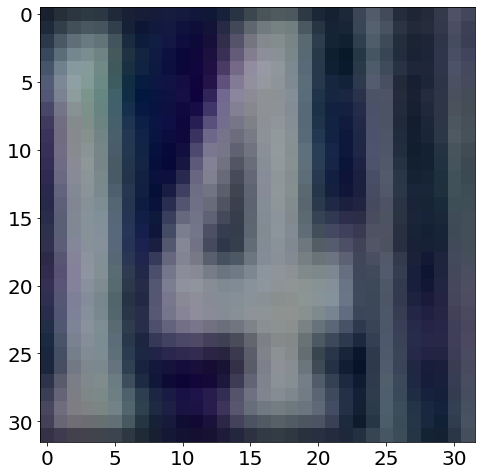

In [133]:
plt.imshow(train_back[0])
plt.show()

# Define VAE's decoder and encoder

In [140]:
enc = Encoder()
dec = Decoder()

mse = nn.MSELoss()
kldiv = nn.KLDivLoss(reduction='batchmean', log_target=True)
opt_e = torch.optim.Adam(dec.parameters())
opt_d = torch.optim.Adam(enc.parameters())

standard_prior = torch.distributions.MultivariateNormal(torch.zeros(16), torch.diag(torch.ones(16)))

# Main training loop

mse = 212.08226013183594
kdd = -0.002742989221587777
mse = 230.1419219970703
kdd = -0.0015280409716069698
mse = 193.57061767578125
kdd = -0.00040820727008394897
mse = 145.86065673828125
kdd = -1.017398426483851e-05
mse = 131.74453735351562
kdd = -5.635628630429323e-10
Iteration 5 : 5 - loss = 913.3952941894531
mse = 75.55387878417969
kdd = -7.587227059957513e-07
mse = 121.69214630126953
kdd = -5.903766577830538e-06
mse = 107.69473266601562
kdd = -9.34341733227484e-06
mse = 85.00234985351562
kdd = -6.064792160032084e-06
mse = 57.14791488647461
kdd = -7.904245080680994e-07
Iteration 10 : 5 - loss = 447.0909996032715
mse = 62.030818939208984
kdd = -4.599554870310385e-08
mse = 68.88390350341797
kdd = -6.343721992152496e-08
mse = 42.78335189819336
kdd = -2.4909903117986687e-07
mse = 45.81834030151367
kdd = -8.652850169710291e-07
mse = 46.997257232666016
kdd = -4.678012373915408e-06
Iteration 15 : 5 - loss = 266.51366806030273
mse = 55.8567008972168
kdd = -2.086615040752804e-06
mse = 39.4947

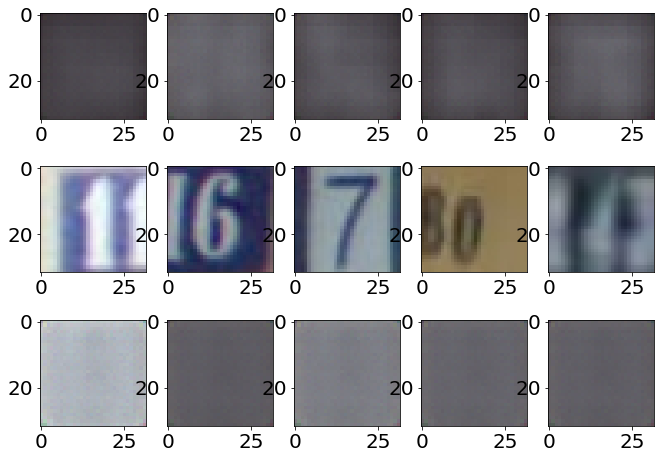

Total loss on epoch 0 = 3440.739191055298
mse = 17.266786575317383
kdd = -7.710048521403223e-05
mse = 16.501060485839844
kdd = -0.00019491507555358112
mse = 17.796375274658203
kdd = -0.00014667828509118408
mse = 16.749216079711914
kdd = -7.197434024419636e-05
mse = 19.06048583984375
kdd = -9.952432446880266e-05
Iteration 5 : 5 - loss = 87.37333488464355
mse = 16.7714786529541
kdd = -9.78885727818124e-05
mse = 15.66877269744873
kdd = -9.636453614803031e-05
mse = 16.492326736450195
kdd = -7.923600060166791e-05
mse = 18.368640899658203
kdd = -9.175508603220806e-05
mse = 16.587526321411133
kdd = -0.00011919795360881835
Iteration 10 : 5 - loss = 83.88826179504395
mse = 15.354477882385254
kdd = -6.463407771661878e-05
mse = 15.335930824279785
kdd = -5.7644847402116284e-05
mse = 16.09287452697754
kdd = -0.00010441445920150727
mse = 18.391244888305664
kdd = -6.865142495371401e-05
mse = 17.180017471313477
kdd = -0.0001218025863636285
Iteration 15 : 5 - loss = 82.35412788391113
mse = 18.223482131

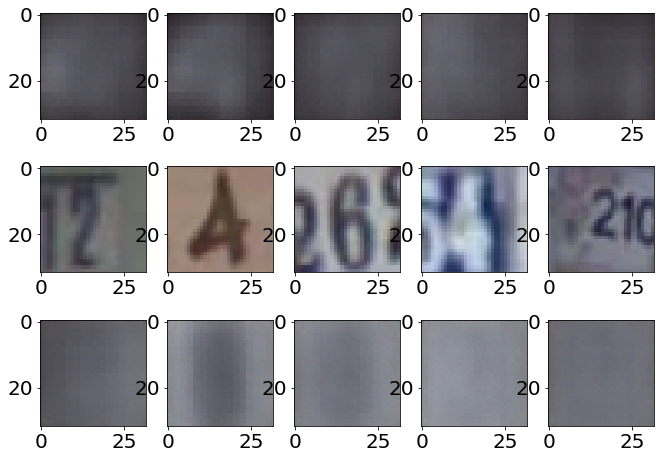

Total loss on epoch 1 = 1560.6227960586548
mse = 14.359865188598633
kdd = -2.1746607671957463e-05
mse = 15.986266136169434
kdd = -2.4719838620512746e-05
mse = 14.143388748168945
kdd = -4.788691512658261e-05
mse = 13.229700088500977
kdd = -3.741285763680935e-05
mse = 12.38415241241455
kdd = -8.207034261431545e-05
Iteration 5 : 5 - loss = 70.10315895080566
mse = 13.076656341552734
kdd = -3.4918677556561306e-05
mse = 11.848258018493652
kdd = -3.4707627492025495e-05
mse = 13.191800117492676
kdd = -4.031243588542566e-05
mse = 11.81896686553955
kdd = -3.616020694607869e-05
mse = 15.261061668395996
kdd = -3.425300383241847e-05
Iteration 10 : 5 - loss = 65.19656276702881
mse = 13.24633502960205
kdd = -2.997523915837519e-05
mse = 16.611854553222656
kdd = -4.4530312152346596e-05
mse = 13.300888061523438
kdd = -2.051671799563337e-05
mse = 13.75955867767334
kdd = -4.393015842651948e-05
mse = 13.413588523864746
kdd = -3.0501718356390484e-05
Iteration 15 : 5 - loss = 70.33205604553223
mse = 13.66870

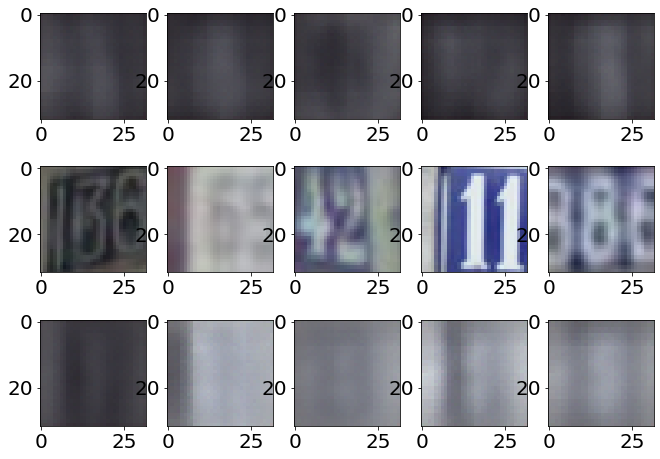

Total loss on epoch 2 = 1262.1539268493652
mse = 13.1625337600708
kdd = -1.2114628589188214e-05
mse = 11.609854698181152
kdd = -9.163967661152128e-06
mse = 13.213061332702637
kdd = -1.283590063394513e-05
mse = 12.230462074279785
kdd = -3.868311523547163e-06
mse = 10.99957275390625
kdd = -3.431291588640306e-06
Iteration 5 : 5 - loss = 61.2154426574707
mse = 12.836116790771484
kdd = -3.5768732686847216e-06
mse = 10.8576021194458
kdd = -1.402178531861864e-05
mse = 13.1480131149292
kdd = -2.1506451957975514e-05
mse = 11.434340476989746
kdd = -6.543509698531125e-06
mse = 9.777085304260254
kdd = -1.7513249986222945e-05
Iteration 10 : 5 - loss = 58.053093910217285
mse = 10.84850788116455
kdd = -1.2791703738912474e-05
mse = 11.470773696899414
kdd = -4.3558497964113485e-06
mse = 9.749201774597168
kdd = -3.9319111238000914e-06
mse = 11.522334098815918
kdd = -1.4835475667496212e-05
mse = 10.677577018737793
kdd = -1.1804762834799476e-05
Iteration 15 : 5 - loss = 54.26834678649902
mse = 10.89337444

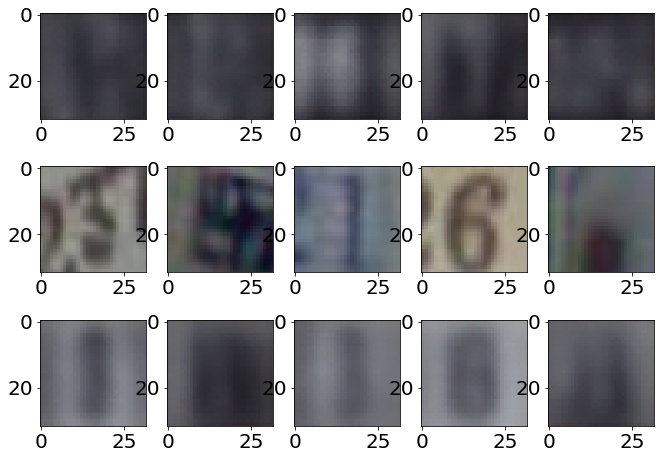

Total loss on epoch 3 = 1136.3522539138794
mse = 11.659651756286621
kdd = -3.5531309549696743e-05
mse = 10.430827140808105
kdd = -1.2048960343236104e-05
mse = 10.533788681030273
kdd = -2.4492481315974146e-05
mse = 10.002227783203125
kdd = -3.734225174412131e-05
mse = 9.82361125946045
kdd = -3.0203980713849887e-05
Iteration 5 : 5 - loss = 52.44996643066406
mse = 10.198816299438477
kdd = -7.655467925360426e-06
mse = 11.531160354614258
kdd = -2.0414698155946098e-05
mse = 10.017047882080078
kdd = -1.0733514500316232e-05
mse = 9.985597610473633
kdd = -4.383605846669525e-05
mse = 10.16856575012207
kdd = -1.6830817912705243e-05
Iteration 10 : 5 - loss = 51.90108871459961
mse = 10.056426048278809
kdd = -4.249264020472765e-05
mse = 10.127853393554688
kdd = -1.990740747714881e-05
mse = 9.591325759887695
kdd = -7.4136260082013905e-06
mse = 11.618382453918457
kdd = -1.0521432159293909e-05
mse = 10.223570823669434
kdd = -2.5269137040595524e-05
Iteration 15 : 5 - loss = 51.61745262145996
mse = 8.114

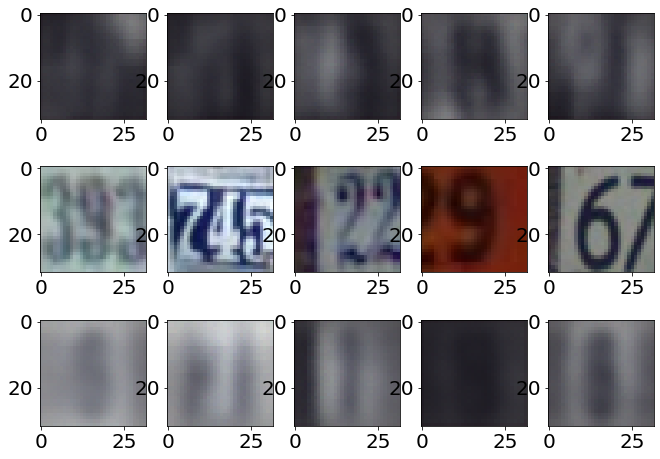

Total loss on epoch 4 = 979.7581896781921
mse = 10.587764739990234
kdd = -2.108850139848073e-06
mse = 9.8401517868042
kdd = -1.5330060705309734e-05
mse = 9.738022804260254
kdd = -2.0735968064400367e-05
mse = 10.796235084533691
kdd = -5.668830453942064e-06
mse = 10.355982780456543
kdd = -5.1381048251641914e-06
Iteration 5 : 5 - loss = 51.318108558654785
mse = 10.144930839538574
kdd = -1.921770308399573e-05
mse = 8.590460777282715
kdd = -5.459983185573947e-06
mse = 10.624942779541016
kdd = -1.1072950655943714e-05
mse = 9.965481758117676
kdd = -2.155710171791725e-05
mse = 10.32245922088623
kdd = -8.120830898405984e-06
Iteration 10 : 5 - loss = 49.64820861816406
mse = 9.816444396972656
kdd = -3.5515920444595395e-06
mse = 8.003369331359863
kdd = -4.133460151933832e-06
mse = 10.448185920715332
kdd = -9.094573215406854e-06
mse = 10.680315971374512
kdd = -3.7136687751626596e-06
mse = 9.556747436523438
kdd = -1.275157501368085e-05
Iteration 15 : 5 - loss = 48.50502967834473
mse = 13.20206260681

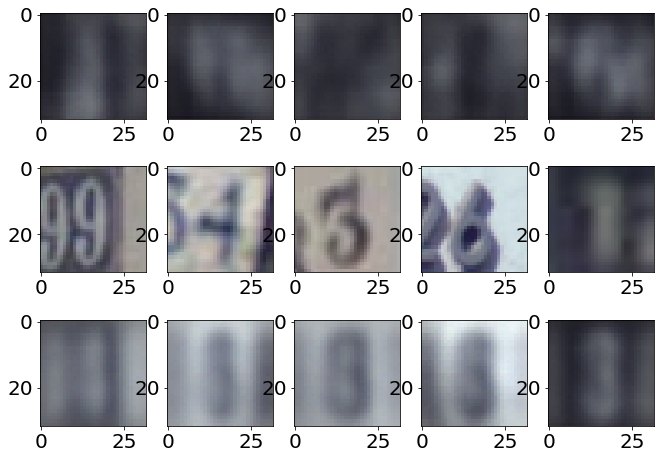

Total loss on epoch 5 = 1043.0915479660034
mse = 10.069354057312012
kdd = -2.9173617804190144e-05
mse = 8.217425346374512
kdd = -1.068186520569725e-05
mse = 8.290970802307129
kdd = -2.2976624677539803e-05
mse = 9.31497573852539
kdd = -2.5678897145553492e-05
mse = 8.357985496520996
kdd = -1.4175765500112902e-05
Iteration 5 : 5 - loss = 44.25060844421387
mse = 8.47748851776123
kdd = -2.4703938834136352e-05
mse = 9.58513069152832
kdd = -1.4977189493947662e-05
mse = 8.543128967285156
kdd = -1.1377301234460901e-05
mse = 9.111804008483887
kdd = -1.8168933820561506e-05
mse = 9.027823448181152
kdd = -1.678632543189451e-05
Iteration 10 : 5 - loss = 44.74528884887695
mse = 7.78517484664917
kdd = -1.9713832443812862e-05
mse = 7.954124450683594
kdd = -1.86836659850087e-05
mse = 7.9281535148620605
kdd = -1.6765114196459763e-05
mse = 8.97436237335205
kdd = -2.964612576761283e-05
mse = 9.309330940246582
kdd = -2.0072890038136393e-05
Iteration 15 : 5 - loss = 41.95104169845581
mse = 9.10749626159668
k

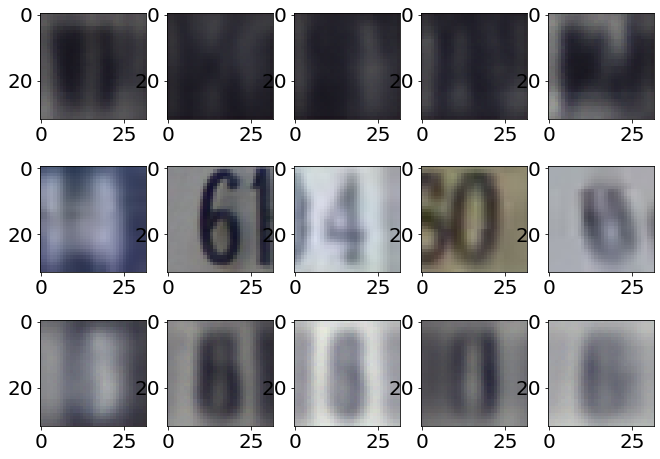

Total loss on epoch 6 = 833.5627508163452
mse = 7.460877418518066
kdd = -1.6950136341620237e-05
mse = 9.417952537536621
kdd = -1.975692157429876e-06
mse = 8.040802001953125
kdd = -1.1340455785102677e-05
mse = 9.032882690429688
kdd = -1.0299782843503635e-05
mse = 7.309614181518555
kdd = -1.6962205336312763e-05
Iteration 5 : 5 - loss = 41.262070655822754
mse = 8.664551734924316
kdd = -3.1178481094684685e-06
mse = 7.714821815490723
kdd = -4.547387106867973e-06
mse = 8.677166938781738
kdd = -3.811216174653964e-06
mse = 8.633176803588867
kdd = -5.786706879007397e-06
mse = 9.066658973693848
kdd = -2.3900278733890445e-07
Iteration 10 : 5 - loss = 42.7563591003418
mse = 7.611860275268555
kdd = -5.651249011862092e-06
mse = 7.068325996398926
kdd = -6.927092726982664e-06
mse = 8.054908752441406
kdd = -8.794521818344947e-06
mse = 7.7366790771484375
kdd = -2.1949834263068624e-05
mse = 7.565296173095703
kdd = -2.566799048508983e-05
Iteration 15 : 5 - loss = 38.03700113296509
mse = 7.466219902038574


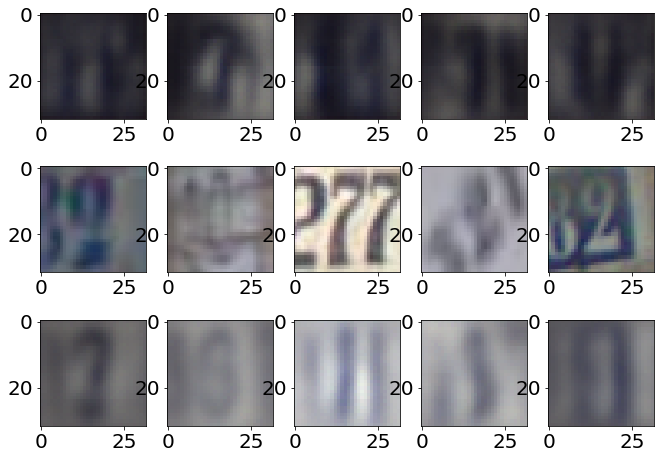

Total loss on epoch 7 = 777.1616263389587
mse = 6.808963775634766
kdd = -1.2966060239705257e-05
mse = 8.515564918518066
kdd = -3.0850414987071417e-06
mse = 8.125123977661133
kdd = -1.9215294742025435e-06
mse = 7.9354376792907715
kdd = -5.309951575327432e-06
mse = 7.80643892288208
kdd = -3.133447989966953e-06
Iteration 5 : 5 - loss = 39.191503047943115
mse = 8.410862922668457
kdd = -4.112098849873291e-06
mse = 8.183819770812988
kdd = -2.850139253496309e-06
mse = 7.9024176597595215
kdd = -1.0511917935218662e-05
mse = 7.353703022003174
kdd = -8.746154662730987e-07
mse = 8.540350914001465
kdd = -6.110828962846426e-06
Iteration 10 : 5 - loss = 40.391130447387695
mse = 8.5153169631958
kdd = -4.416235697135562e-06
mse = 6.65557861328125
kdd = -1.4192843309501768e-06
mse = 7.3383469581604
kdd = -1.6295422256007441e-06
mse = 10.19789981842041
kdd = -1.1026443189621205e-06
mse = 7.732259273529053
kdd = -4.105624611838721e-06
Iteration 15 : 5 - loss = 40.43938875198364
mse = 8.285264015197754
kdd

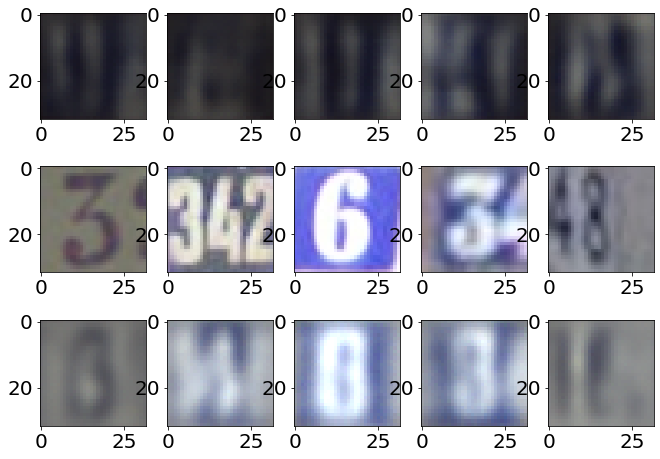

Total loss on epoch 8 = 739.5900230407715
mse = 7.468910217285156
kdd = -1.13111764221685e-05
mse = 8.32086181640625
kdd = -9.81164976110449e-06
mse = 7.834291934967041
kdd = -4.288050149625633e-06
mse = 6.984817028045654
kdd = -1.2624815099115949e-05
mse = 6.507519721984863
kdd = -1.496165987191489e-05
Iteration 5 : 5 - loss = 37.11634826660156
mse = 6.993698596954346
kdd = -9.112655789067503e-06
mse = 8.096120834350586
kdd = -8.128668014251161e-06
mse = 6.910252094268799
kdd = -4.187365448160563e-06
mse = 8.219018936157227
kdd = -3.785625040109153e-06
mse = 8.520750045776367
kdd = -1.0069604286400136e-05
Iteration 10 : 5 - loss = 38.7398042678833
mse = 7.612449645996094
kdd = -2.5017268399096793e-06
mse = 7.0266432762146
kdd = -4.3682991446303276e-08
mse = 6.535507678985596
kdd = -9.01287239685189e-06
mse = 6.999152183532715
kdd = -3.713802925631171e-06
mse = 6.2673726081848145
kdd = -8.666958819958381e-06
Iteration 15 : 5 - loss = 34.44110155105591
mse = 7.107717514038086
kdd = -2.7

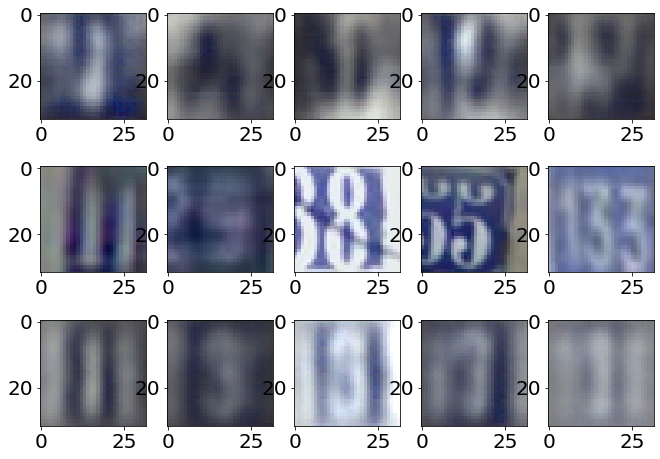

Total loss on epoch 9 = 1343.185278892517
mse = 7.910996913909912
kdd = -8.367398550035432e-05
mse = 6.689016342163086
kdd = -7.428971730405465e-05
mse = 7.5214152336120605
kdd = -0.00012939341831952333
mse = 6.837396621704102
kdd = -9.823928849073127e-05
mse = 6.841670036315918
kdd = -0.00010389119415776804
Iteration 5 : 5 - loss = 35.80000591278076
mse = 7.520410060882568
kdd = -0.00013134555774740875
mse = 7.418137073516846
kdd = -0.0001213110881508328
mse = 6.978792190551758
kdd = -0.00012675633479375392
mse = 6.7281670570373535
kdd = -0.00010311576625099406
mse = 7.690398693084717
kdd = -0.00012039905413985252
Iteration 10 : 5 - loss = 36.33530282974243
mse = 7.124238967895508
kdd = -8.53117962833494e-05
mse = 8.148624420166016
kdd = -0.00013795327686239034
mse = 5.807797908782959
kdd = -0.00016231357585638762
mse = 7.46530294418335
kdd = -0.00013557424244936556
mse = 7.100401878356934
kdd = -7.746512710582465e-05
Iteration 15 : 5 - loss = 35.64576768875122
mse = 7.309722423553467

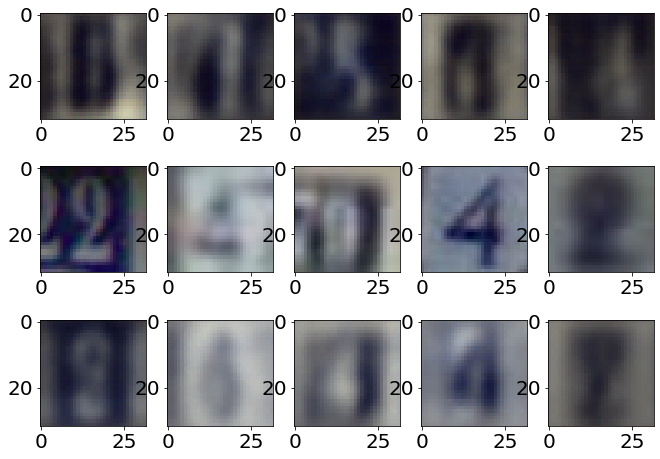

Total loss on epoch 10 = 694.3342700004578
mse = 6.665770530700684
kdd = -0.00011065544822486117
mse = 6.30855131149292
kdd = -5.480057006934658e-05
mse = 6.376244068145752
kdd = -6.2914339650888e-05
mse = 6.350884914398193
kdd = -0.0001367955410387367
mse = 6.1551384925842285
kdd = -5.889577732887119e-05
Iteration 5 : 5 - loss = 31.856164932250977
mse = 6.935323715209961
kdd = -5.7285138609586284e-05
mse = 7.111817836761475
kdd = -7.853582064853981e-05
mse = 5.581045150756836
kdd = -4.305391485104337e-05
mse = 7.019262790679932
kdd = -9.25720960367471e-05
mse = 7.411006450653076
kdd = -5.737467290600762e-05
Iteration 10 : 5 - loss = 34.05812740325928
mse = 6.457516193389893
kdd = -5.5258788052015007e-05
mse = 6.009184837341309
kdd = -0.0001067865377990529
mse = 5.578251838684082
kdd = -0.00010075003956444561
mse = 6.113419055938721
kdd = -0.00011152295337524265
mse = 5.954589366912842
kdd = -6.380854028975591e-05
Iteration 15 : 5 - loss = 30.112523078918457
mse = 7.870590686798096
kdd

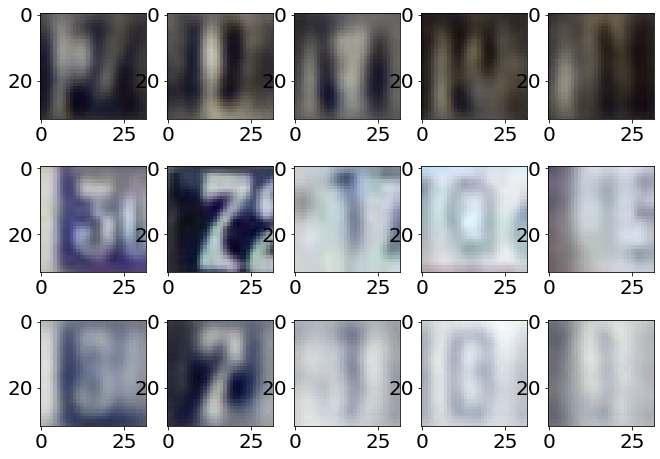

Total loss on epoch 11 = 643.7927966117859
mse = 5.969274044036865
kdd = -4.8015233915066347e-05
mse = 6.292734622955322
kdd = -6.535433931276202e-05
mse = 7.3170166015625
kdd = -6.922334432601929e-05
mse = 5.959343910217285
kdd = -6.281211972236633e-05
mse = 6.675398826599121
kdd = -7.358818402281031e-05
Iteration 5 : 5 - loss = 32.213449001312256
mse = 6.4176836013793945
kdd = -6.21854342170991e-05
mse = 6.823936939239502
kdd = -5.7912664487957954e-05
mse = 6.570986747741699
kdd = -7.107650162652135e-05
mse = 6.448282241821289
kdd = -7.56629160605371e-05
mse = 5.622990131378174
kdd = -4.1750510717974976e-05
Iteration 10 : 5 - loss = 31.8835711479187
mse = 5.688018798828125
kdd = -9.807554306462407e-05
mse = 6.171570301055908
kdd = -7.100490620359778e-05
mse = 6.216021537780762
kdd = -2.293273246323224e-05
mse = 6.1285247802734375
kdd = -2.297238097526133e-05
mse = 6.75341796875
kdd = -4.960606383974664e-05
Iteration 15 : 5 - loss = 30.95728874206543
mse = 6.06277322769165
kdd = -2.62

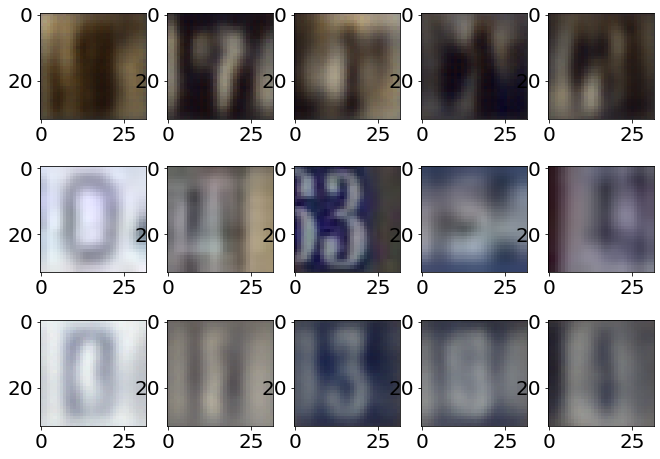

Total loss on epoch 12 = 613.7800607681274
mse = 6.807703495025635
kdd = -2.2130750949145295e-05
mse = 5.080812931060791
kdd = -4.106555206817575e-05
mse = 6.926966190338135
kdd = -3.736592407221906e-05
mse = 6.611619472503662
kdd = -3.0098442948656157e-05
mse = 5.932421684265137
kdd = -4.548261495074257e-05
Iteration 5 : 5 - loss = 31.35934829711914
mse = 7.085039138793945
kdd = -7.455600280081853e-05
mse = 6.303481101989746
kdd = -2.4724511604290456e-05
mse = 6.0451979637146
kdd = -4.5905264414614066e-05
mse = 5.142185211181641
kdd = -3.627371188485995e-05
mse = 5.75847053527832
kdd = -3.607111284509301e-05
Iteration 10 : 5 - loss = 30.33415651321411
mse = 5.721600532531738
kdd = -7.124020339688286e-05
mse = 5.7301344871521
kdd = -8.583262388128787e-05
mse = 6.458315372467041
kdd = -4.395746873342432e-05
mse = 5.642788887023926
kdd = -5.032594708609395e-05
mse = 6.164081573486328
kdd = -4.5286120439413935e-05
Iteration 15 : 5 - loss = 29.71662425994873
mse = 5.654889106750488
kdd = -

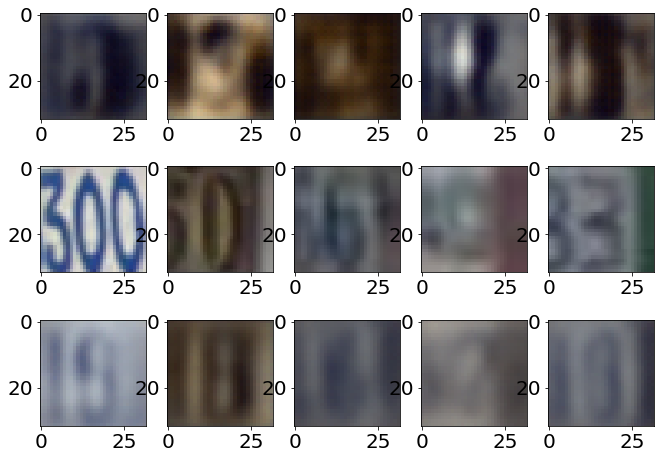

Total loss on epoch 13 = 597.2803378105164
mse = 5.303217887878418
kdd = -4.483037264435552e-05
mse = 5.807149410247803
kdd = -3.4261029213666916e-05
mse = 6.812157154083252
kdd = -5.879748641746119e-05
mse = 5.895359039306641
kdd = -2.8657519578700885e-05
mse = 5.471694469451904
kdd = -6.162393401609734e-05
Iteration 5 : 5 - loss = 29.289350032806396
mse = 6.376312255859375
kdd = -3.815684613073245e-05
mse = 6.862937927246094
kdd = -1.7694766938802786e-05
mse = 5.572840213775635
kdd = -4.431123670656234e-05
mse = 6.422327041625977
kdd = -7.391124381683767e-05
mse = 6.205437660217285
kdd = -8.592211088398471e-05
Iteration 10 : 5 - loss = 31.439595222473145
mse = 5.85332727432251
kdd = -4.6980578190414235e-05
mse = 5.266268730163574
kdd = -3.780181577894837e-05
mse = 5.877620220184326
kdd = -3.152260615024716e-05
mse = 7.7563958168029785
kdd = -1.1241851098020561e-05
mse = 5.895631313323975
kdd = -6.262490205699578e-05
Iteration 15 : 5 - loss = 30.64905309677124
mse = 6.109129905700684


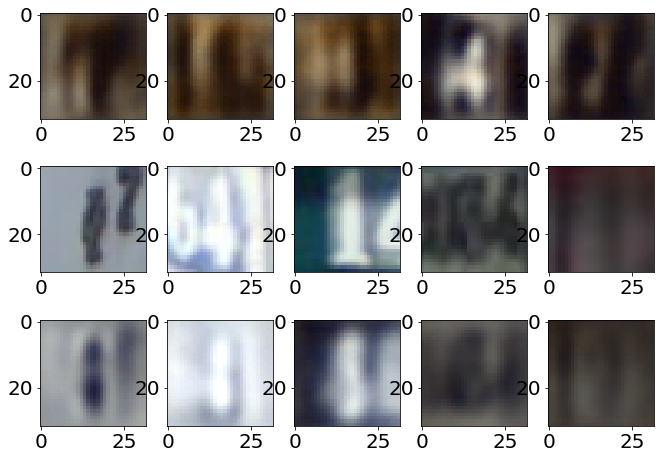

Total loss on epoch 14 = 586.0857939720154
mse = 6.334079265594482
kdd = -4.110472946194932e-05
mse = 7.209341049194336
kdd = -4.2333867895649746e-05
mse = 4.783567428588867
kdd = -6.302148540271446e-05
mse = 5.708343505859375
kdd = -4.3912019464187324e-05
mse = 5.928701400756836
kdd = -6.420691352104768e-05
Iteration 5 : 5 - loss = 29.963778018951416
mse = 5.687347412109375
kdd = -3.968017699662596e-05
mse = 5.610677719116211
kdd = -5.188600334804505e-05
mse = 5.382973670959473
kdd = -3.033950451936107e-05
mse = 5.163914203643799
kdd = -6.149667024146765e-05
mse = 5.005439281463623
kdd = -5.6360397138632834e-05
Iteration 10 : 5 - loss = 26.850112438201904
mse = 5.925835609436035
kdd = -5.6129967560991645e-05
mse = 5.591989994049072
kdd = -6.283909169724211e-05
mse = 5.139106273651123
kdd = -6.078911246731877e-05
mse = 6.225327968597412
kdd = -2.271056109748315e-05
mse = 5.972518444061279
kdd = -6.678538920823485e-05
Iteration 15 : 5 - loss = 28.854508876800537
mse = 6.250062465667725


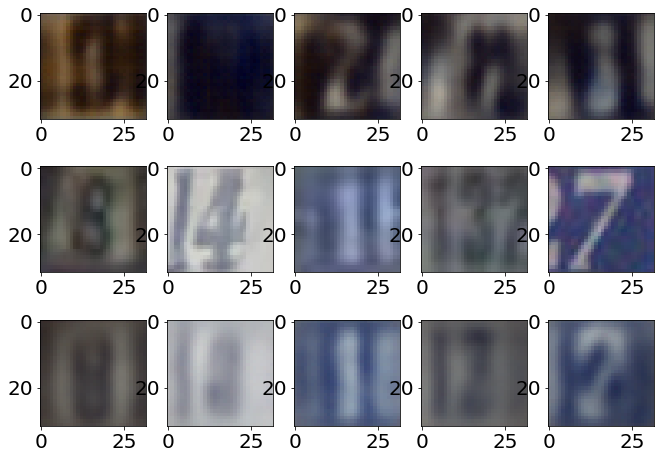

Total loss on epoch 15 = 582.2487034797668
mse = 5.038204669952393
kdd = -3.800742342718877e-05
mse = 5.666157245635986
kdd = -5.058409442426637e-05
mse = 5.423960208892822
kdd = -7.558424113085493e-05
mse = 5.863997459411621
kdd = -4.060361607116647e-05
mse = 6.453725337982178
kdd = -2.5201359676430002e-05
Iteration 5 : 5 - loss = 28.445814609527588
mse = 5.868001461029053
kdd = -4.9743830459192395e-05
mse = 5.6603264808654785
kdd = -5.5829252232797444e-05
mse = 6.058703422546387
kdd = -5.308195250108838e-05
mse = 5.737797260284424
kdd = -7.02811885275878e-05
mse = 6.023554801940918
kdd = -2.977454278152436e-05
Iteration 10 : 5 - loss = 29.348125457763672
mse = 6.027192115783691
kdd = -4.082481245859526e-05
mse = 7.130216598510742
kdd = -3.7681031244574115e-05
mse = 5.374715805053711
kdd = -8.13960941741243e-05
mse = 6.4792304039001465
kdd = -3.380694761290215e-05
mse = 5.897083759307861
kdd = -2.9359791369643062e-05
Iteration 15 : 5 - loss = 30.908215045928955
mse = 5.750653266906738

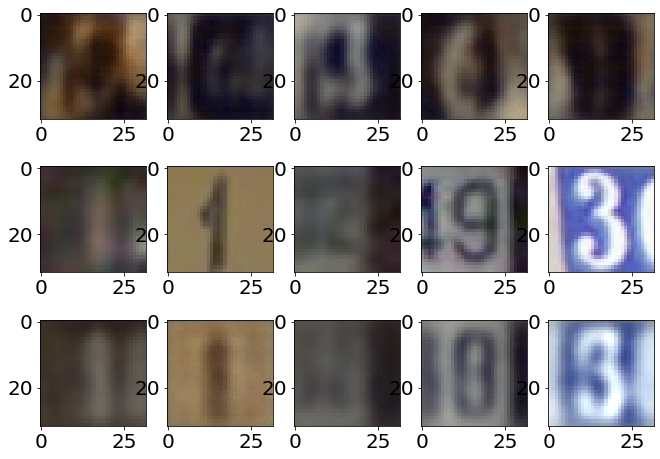

Total loss on epoch 16 = 573.658061504364
mse = 5.787111759185791
kdd = -6.881786248413846e-05
mse = 5.935509204864502
kdd = -2.1552543330471963e-05
mse = 5.870036602020264
kdd = -5.4607335187029094e-05
mse = 5.436722755432129
kdd = -6.0612746892729774e-05
mse = 5.525187969207764
kdd = -6.0102251154603437e-05
Iteration 5 : 5 - loss = 28.55430269241333
mse = 5.476685523986816
kdd = -5.1104536396451294e-05
mse = 5.377654552459717
kdd = -5.509236143552698e-05
mse = 5.206125736236572
kdd = -9.528579539619386e-05
mse = 4.963494777679443
kdd = -6.076143108657561e-05
mse = 5.079970836639404
kdd = -7.689110498176888e-05
Iteration 10 : 5 - loss = 26.10359239578247
mse = 6.39019250869751
kdd = -3.806964377872646e-05
mse = 5.395208358764648
kdd = -6.752718763891608e-05
mse = 6.588438034057617
kdd = -4.9187030526809394e-05
mse = 5.660149097442627
kdd = -4.7409674152731895e-05
mse = 6.076136112213135
kdd = -3.759245009860024e-05
Iteration 15 : 5 - loss = 30.10988426208496
mse = 5.72559928894043
kdd

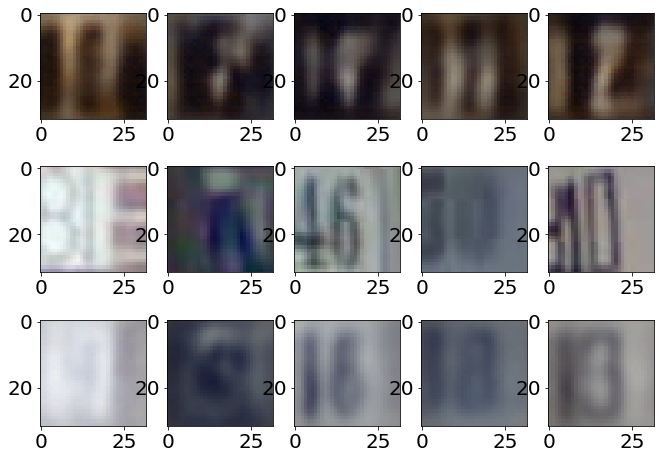

Total loss on epoch 17 = 577.3058815002441
mse = 5.683758735656738
kdd = -3.838735574390739e-05
mse = 6.00473165512085
kdd = -6.512949767056853e-05
mse = 5.310086727142334
kdd = -4.077452467754483e-05
mse = 5.91516637802124
kdd = -3.375339292688295e-05
mse = 6.909152984619141
kdd = -8.475398499285802e-05
Iteration 5 : 5 - loss = 29.822632789611816
mse = 7.346957206726074
kdd = -4.060918581672013e-05
mse = 5.390673637390137
kdd = -3.446970004006289e-05
mse = 5.694537162780762
kdd = -5.701656482415274e-05
mse = 5.8609938621521
kdd = -8.232126128859818e-05
mse = 5.687082767486572
kdd = -4.4611886551138014e-05
Iteration 10 : 5 - loss = 29.979985237121582
mse = 5.577023029327393
kdd = -3.8619094993919134e-05
mse = 6.294248580932617
kdd = -3.668275167001411e-05
mse = 5.52949333190918
kdd = -7.031274435576051e-05
mse = 5.716312885284424
kdd = -2.8450167519622482e-05
mse = 5.211646556854248
kdd = -2.2318423361866735e-05
Iteration 15 : 5 - loss = 28.32852792739868
mse = 6.812286376953125
kdd = 

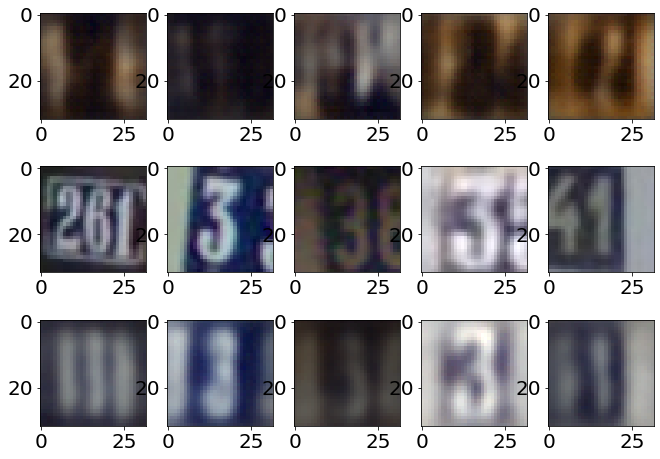

Total loss on epoch 18 = 565.4228515625
mse = 5.417920112609863
kdd = -6.893539102748036e-05
mse = 6.440506935119629
kdd = -9.775889338925481e-05
mse = 6.042018890380859
kdd = -7.379991438938305e-05
mse = 5.928719997406006
kdd = -4.2700157791841775e-05
mse = 6.618603706359863
kdd = -4.267130498192273e-05
Iteration 5 : 5 - loss = 30.44744348526001
mse = 5.0097198486328125
kdd = -6.229498103493825e-05
mse = 5.895090103149414
kdd = -7.140767411328852e-05
mse = 5.708371639251709
kdd = -7.206498412415385e-05
mse = 6.113199234008789
kdd = -9.094960114452988e-05
mse = 5.308621406555176
kdd = -5.026805229135789e-05
Iteration 10 : 5 - loss = 28.03465509414673
mse = 5.824460029602051
kdd = -0.00010700255370466039
mse = 5.372554302215576
kdd = -7.717489643255249e-05
mse = 5.148471355438232
kdd = -8.063177665462717e-05
mse = 5.617891311645508
kdd = -4.2117517295992e-05
mse = 5.876008033752441
kdd = -7.954494503792375e-05
Iteration 15 : 5 - loss = 27.838998794555664
mse = 5.141829013824463
kdd = -6

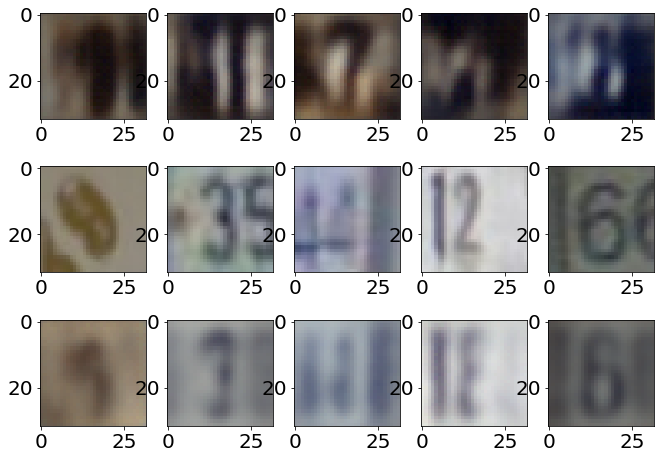

Total loss on epoch 19 = 561.178994178772
mse = 4.880748748779297
kdd = -4.231274579069577e-05
mse = 5.1237688064575195
kdd = -8.299879846163094e-05
mse = 4.836302280426025
kdd = -4.6316214138641953e-05
mse = 5.155128479003906
kdd = -8.518999675288796e-05
mse = 6.689303398132324
kdd = -4.883036308456212e-05
Iteration 5 : 5 - loss = 26.684946060180664
mse = 6.221782684326172
kdd = -3.875170659739524e-05
mse = 5.1950507164001465
kdd = -5.465637514134869e-05
mse = 5.22075080871582
kdd = -5.761520878877491e-05
mse = 5.842718601226807
kdd = -6.985820073168725e-05
mse = 5.700000286102295
kdd = -5.2961910114390776e-05
Iteration 10 : 5 - loss = 28.180028915405273
mse = 5.750131130218506
kdd = -7.732267113169655e-05
mse = 5.741954326629639
kdd = -8.562870061723515e-05
mse = 6.598588943481445
kdd = -6.106456567067653e-05
mse = 5.954686164855957
kdd = -4.071794683113694e-05
mse = 5.354432582855225
kdd = -7.594736234750599e-05
Iteration 15 : 5 - loss = 29.399452686309814
mse = 5.10352087020874
kdd

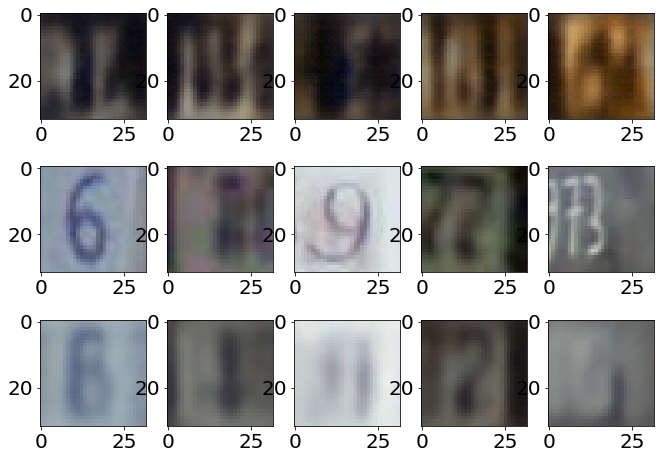

Total loss on epoch 20 = 565.2585687637329
mse = 5.136471748352051
kdd = -8.022373367566615e-05
mse = 5.883923053741455
kdd = -8.795081521384418e-05
mse = 5.96403169631958
kdd = -3.3320528018521145e-05
mse = 5.155520915985107
kdd = -6.885187758598477e-05
mse = 6.601724624633789
kdd = -7.8318924352061e-05
Iteration 5 : 5 - loss = 28.741323947906494
mse = 5.384561538696289
kdd = -8.12366051832214e-05
mse = 6.508141040802002
kdd = -6.712367758154869e-05
mse = 5.419490337371826
kdd = -0.00010268890764564276
mse = 5.440910816192627
kdd = -0.00010049772390630096
mse = 5.205689907073975
kdd = -0.00010314326209481806
Iteration 10 : 5 - loss = 27.95833921432495
mse = 6.168792247772217
kdd = -0.00010366567585151643
mse = 5.100639820098877
kdd = -3.522697079461068e-05
mse = 6.461419582366943
kdd = -4.488533522817306e-05
mse = 5.78900146484375
kdd = -5.4688742238795385e-05
mse = 6.882611274719238
kdd = -6.321661203401163e-05
Iteration 15 : 5 - loss = 30.402162551879883
mse = 5.997912883758545
kdd 

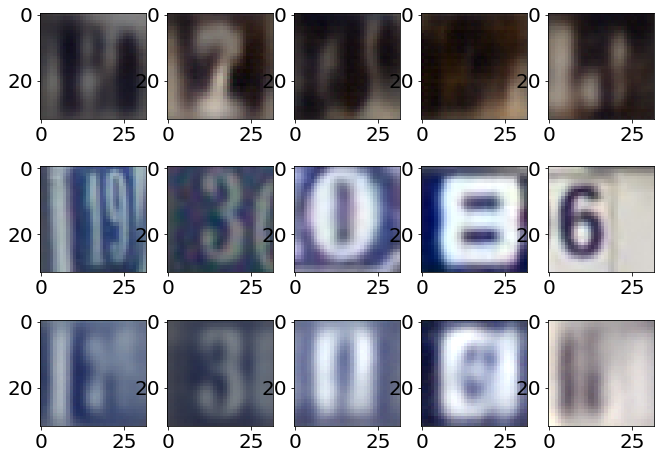

Total loss on epoch 21 = 558.9208250045776
mse = 6.940883159637451
kdd = -7.180328975664452e-05
mse = 6.208139896392822
kdd = -5.528009569388814e-05
mse = 4.763315200805664
kdd = -5.22578447998967e-05
mse = 4.868200302124023
kdd = -8.258033631136641e-05
mse = 5.599815368652344
kdd = -9.224635869031772e-05
Iteration 5 : 5 - loss = 28.37999963760376
mse = 5.828340530395508
kdd = -8.037855877773836e-05
mse = 5.914924621582031
kdd = -5.436038918560371e-05
mse = 5.641892910003662
kdd = -6.972606934141368e-05
mse = 5.3371782302856445
kdd = -7.638690294697881e-05
mse = 6.207606792449951
kdd = -6.742247205693275e-05
Iteration 10 : 5 - loss = 28.92959499359131
mse = 5.515831470489502
kdd = -7.541630475316197e-05
mse = 5.207674980163574
kdd = -6.308556476142257e-05
mse = 5.7621049880981445
kdd = -8.89340735739097e-05
mse = 5.199784278869629
kdd = -7.189543248387054e-05
mse = 5.117640018463135
kdd = -5.95471246924717e-05
Iteration 15 : 5 - loss = 26.802676677703857
mse = 5.795979976654053
kdd = -

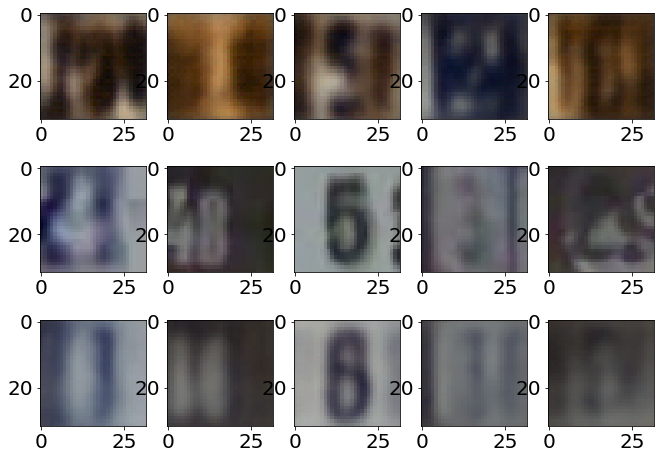

Total loss on epoch 22 = 585.229498386383
mse = 5.168140411376953
kdd = -5.923094431636855e-05
mse = 6.203358173370361
kdd = -8.073670323938131e-05
mse = 5.195109844207764
kdd = -5.528352630790323e-05
mse = 4.998710632324219
kdd = -0.00011467825243016705
mse = 5.183708667755127
kdd = -0.00010344441398046911
Iteration 5 : 5 - loss = 26.74861478805542
mse = 5.627254962921143
kdd = -8.568909834139049e-05
mse = 5.894859790802002
kdd = -0.00010372058022767305
mse = 6.2784342765808105
kdd = -9.505789785180241e-05
mse = 4.942163467407227
kdd = -0.0001450478594051674
mse = 5.442935466766357
kdd = -0.0001111106394091621
Iteration 10 : 5 - loss = 28.185107231140137
mse = 5.203052997589111
kdd = -0.0001165663416031748
mse = 6.151614665985107
kdd = -3.725789429154247e-05
mse = 6.0992279052734375
kdd = -6.850674981251359e-05
mse = 5.979604721069336
kdd = -7.62624476919882e-05
mse = 5.807604789733887
kdd = -7.572332106065005e-05
Iteration 15 : 5 - loss = 29.24073076248169
mse = 5.704199314117432
kdd

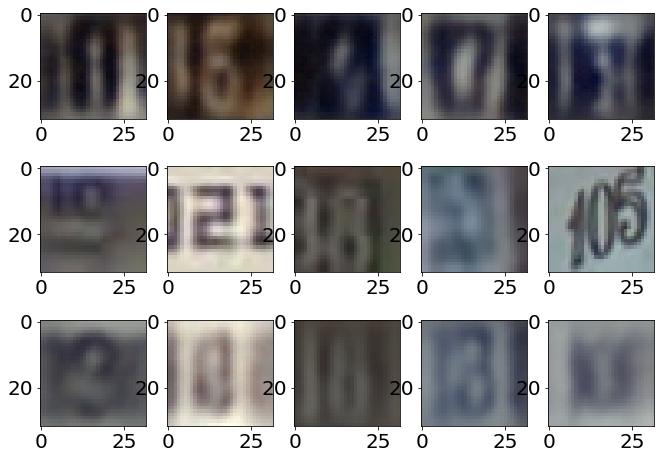

Total loss on epoch 23 = 548.7981915473938
mse = 5.568017959594727
kdd = -0.0001463003281969577
mse = 5.158701419830322
kdd = -6.078137084841728e-05
mse = 4.585570335388184
kdd = -9.096042776945978e-05
mse = 5.124826431274414
kdd = -7.314790855161846e-05
mse = 5.871119976043701
kdd = -0.00010419925092719495
Iteration 5 : 5 - loss = 26.30776071548462
mse = 5.657722473144531
kdd = -0.00011039345554308966
mse = 5.379008769989014
kdd = -8.732434071134776e-05
mse = 4.939897060394287
kdd = -8.145948959281668e-05
mse = 5.178532123565674
kdd = -6.757922528777272e-05
mse = 5.402094841003418
kdd = -0.00011324389197397977
Iteration 10 : 5 - loss = 26.556795120239258
mse = 5.782186985015869
kdd = -0.00011502369306981564
mse = 5.600307941436768
kdd = -8.981092105386779e-05
mse = 5.6867475509643555
kdd = -0.00010049088450614363
mse = 4.1109514236450195
kdd = -0.00012431778304744512
mse = 4.7392473220825195
kdd = -0.0001123496622312814
Iteration 15 : 5 - loss = 25.918899059295654
mse = 6.346764087677

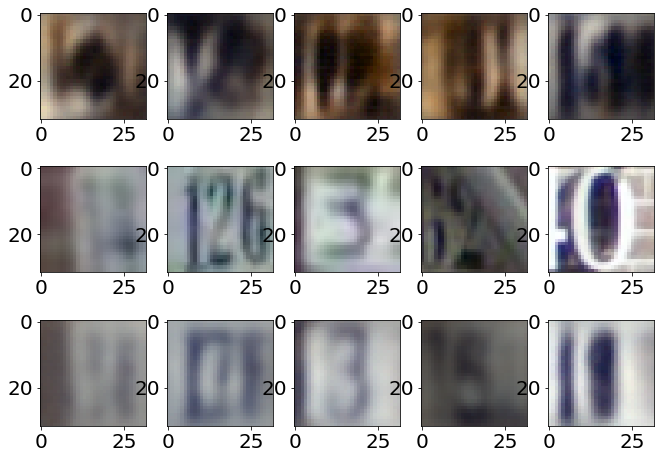

Total loss on epoch 24 = 546.5968165397644
mse = 4.792829990386963
kdd = -6.574705912498757e-05
mse = 5.616359710693359
kdd = -8.20755521999672e-05
mse = 6.411891937255859
kdd = -8.270322723546997e-05
mse = 5.62253999710083
kdd = -9.361530828755349e-05
mse = 5.056464672088623
kdd = -7.996639760676771e-05
Iteration 5 : 5 - loss = 27.499682426452637
mse = 5.2321391105651855
kdd = -6.632965232711285e-05
mse = 4.402264595031738
kdd = -0.00012878717097919434
mse = 5.346980571746826
kdd = -7.86218442954123e-05


KeyboardInterrupt: ignored

In [141]:
for epoch in range(50):
    per = np.random.permutation(10_000)
    L = 0
    Q = 0
    for it in range(100):
        idx = per[it * 100 : (it + 1) * 100]
        data = tensor_train[idx]

        # From data to latent space
        e = enc(data)

        # Reparametrization
        eps = torch.normal(torch.zeros(idx.shape[0]))
        v = torch.einsum('i, ij -> ij', eps, e[:, 16:])
        z = e[:, :16] + v

        # Reconstruction
        d = dec(z)

        # q(z|x)
        q_zx = torch.distributions.Normal(e[:, :16], torch.abs(e[:, 16:]))
        log_prob_zx = q_zx.log_prob(z).sum(dim=1)
        
        # p(z)
        p_z = standard_prior.log_prob(z)


        # Compute loss

        # KL (q_zx || p_z)
        kdd = 100 * kldiv(log_prob_zx, p_z)
        
        # MSE (x|z, x)
        mmss = mse(data.flatten(), d.flatten()) * 1024

        print(f"mse = {mmss.item()}")
        print(f"kdd = {kdd.item()}")
        
        loss = mmss + kdd
        L += loss.item()
        Q += loss.item()

        # Gradient step
        opt_d.zero_grad()
        opt_e.zero_grad()
        
        loss.backward()

        opt_d.step()
        opt_e.step()

        # Chech after 5 steps
        if (it + 1) % 5 == 0:
            print(f"Iteration {it + 1} : 5 - loss = {Q}")
            Q = 0

    ## Check after epoch

    # Sample from model and plot it in 1-st row
    with torch.no_grad():
        z = standard_prior.sample((5,))
        dz = dec(z)
        dz = transform_back(dz)
 
    for i in range(1, 6):
        plt.subplot(3, 5, i)
        plt.imshow(dz[i - 1])

    # Compare image and its reconstruction
    with torch.no_grad():
        ids = np.random.randint(0, 10_000, 5)
        td = train_data[ids]
        
        e = enc(tensor_train[ids])
        eps = torch.normal(torch.zeros(5))
        v = torch.einsum('i, ij -> ij', eps, e[:, 16:])
        z = e[:, :16] + v
        d = dec(z)

        dd = transform_back(d)

    for i in range(1, 6):
        plt.subplot(3, 5, 5 + i) # Original image in 2-nd row
        plt.imshow(td[i - 1])

        plt.subplot(3, 5, 10 + i) # Reconstruction in 3-rd row
        plt.imshow(dd[i - 1])
    
    plt.show()
    print(f"Total loss on epoch {epoch} = {L}")

In [ ]:
def q1_a(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-log p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples from your VAE with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 10 interpolations of length 10 between
      pairs of test images. The output should be those 100 images flattened into
      the specified shape with values in {0, ..., 255}
    """
    enc = Encoder()
    dec = Decoder()

    mse = nn.MSELoss()
    kldiv = nn.KLDivLoss(reduction='batchmean', log_target=True)
    opt_e = torch.optim.Adam(dec.parameters())
    opt_d = torch.optim.Adam(enc.parameters())

    standard_prior = torch.distributions.MultivariateNormal(torch.zeros(16), torch.diag(torch.ones(16)))

### Results
Once you've finished `q1_a`, execute the cells below to visualize and save your results.

Final -ELBO: 104.0417, Recon Loss: 79.3798, KL Loss: 24.6620


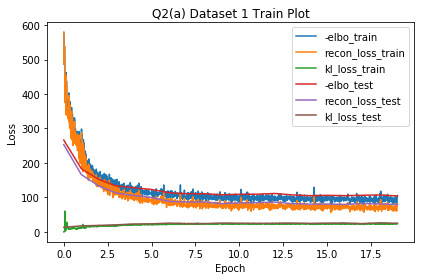

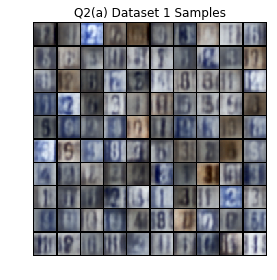

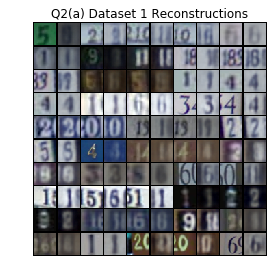

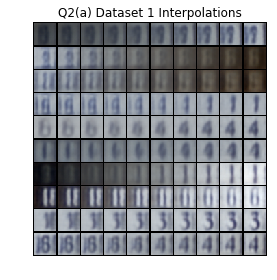

In [ ]:
q1_save_results('a', 1, q1_a)

In [ ]:
q1_save_results('a', 2, q1_a)

In [ ]:
q1_save_results('b', 2, q1_b)